<a href="https://colab.research.google.com/github/yasstake/rusty-bot/blob/main/experimental/colab_drive_mount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ColabでGoogleDriveをマウントする方法を説明します。

## 背景
Colabでは、ランタイムを削除するとDisk上のファイルがクリアされます。RusyBotはシステム上にSqlite3のDBをつくっているためランタイム削除のたびにDBがクリアされることになります。

そこで、DBをGoogleDriveに置く方法を説明します。

BinanceConfig.db_base_dirでDB保存先を変更する方法は、ローカルPCで余裕のあるディスクにDBを構築したい場合にも有効です。

In [ ]:
! pip install rbot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 18.0 MB/s eta 0:00:00


In [ ]:
from rbot import BinanceConfig
from rbot import BinanceMarket

rbot version:  0.2.14
!!! ABSOLUTELY NO WARRANTY !!!
!!!  USE AT YOUR OWN RISK  !!!
See document at https://github.com/yasstake/rusty-bot
 All rights reserved. (c) 2022-2023 rbot developers / yasstake


In [ ]:
# Google Driveをマウントする
from google.colab import drive

drive.mount('/content/drive')

# DBの保存先をGoogle Driveに変更する
config = BinanceConfig.BTCUSDT
config.db_base_dir = '/content/drive/MyDrive'    # MyDrive以下を指定しましたが適宜変更ください

Mounted at /content/drive


In [ ]:
# Binanceのインスタンスを作成する
binance = BinanceMarket(config)

# 具体的に作られたDBのパスを表示
binance.file_name

'/content/drive/MyDrive/DB/BN/SPOT-BTCUSDT.db'

In [ ]:
# データをダウンロードする。１０日分は案外時間がかかります。
binance.download(ndays=10, verbose=True, archive_only=True)

0

In [ ]:
# ダウンロード状況を確認（実際にダウンロードされた日数は、まだアーカイブされていない日があるため１日減ることがあります）
binance

start,end
1702166400000000,1703030399999000
"""2023-12-10T00:00:00.000000""","""2023-12-19T23:59:59.999000"""
days=,9


## 折角なので分析

kashiharaさんの
「国内取引所と海外取引所の短期的値動きの変化」
https://note.com/kashihara1/n/nb3424848a968

を参考にボラティリティ（＝振れ幅？）を分析してみます。

元記事では、おそらくボラティリティが年々小さくなっていてBotにはつらい状況になってきているということを分析されているのだと理解しました。

以下簡単に直近の数字をしらべてみました。

In [ ]:
# 1分足
from rbot import NOW
from rbot import DAYS

# 9日分の４本足を作成します。
ohlcv = binance.ohlcv(start_time=NOW()-DAYS(9), end_time=0, window_sec=60)

In [ ]:
# ohlcvにPorlasのDataFrameで格納されています。
ohlcv.head()

timestamp,open,high,low,close,volume,count
datetime[μs],f64,f64,f64,f64,f64,u32
2023-12-12 02:05:00,41700.0,41700.0,41670.0,41695.98,19.69278,1152
2023-12-12 02:06:00,41695.99,41698.02,41682.01,41693.56,12.41739,743
2023-12-12 02:07:00,41693.57,41709.82,41693.56,41708.2,12.87403,523
2023-12-12 02:08:00,41708.21,41708.21,41670.0,41683.96,20.33856,866
2023-12-12 02:09:00,41683.96,41710.58,41683.95,41710.01,12.47006,661


In [ ]:
# pandasに変換して分析することも可能です。
ohlcv_df = ohlcv.to_pandas(use_pyarrow_extension_array=True)

ohlcv_df.head()

,timestamp,open,high,low,close,volume,count
0,2023-12-12 02:05:00,41700.0,41700.0,41670.0,41695.98,19.69278000000001,1152
1,2023-12-12 02:06:00,41695.99,41698.02,41682.01,41693.56,12.417389999999994,743
2,2023-12-12 02:07:00,41693.57,41709.82,41693.56,41708.2,12.87402999999999,523
3,2023-12-12 02:08:00,41708.21,41708.21,41670.0,41683.96,20.338560000000015,866
4,2023-12-12 02:09:00,41683.96,41710.58,41683.95,41710.01,12.47006,661


In [ ]:
# HighとLowの差分を追加しましょう
range = (ohlcv.get_column('high') - ohlcv.get_column('low')).alias('range')
ohlcv = ohlcv.with_columns(range)

# 差分の終値に対する比率を追加しましょう
range_rate = (range / ohlcv['close']).alias('range_rate')
ohlcv = ohlcv.with_columns(range_rate)

ohlcv.head()


timestamp,open,high,low,close,volume,count,range,range_rate
datetime[μs],f64,f64,f64,f64,f64,u32,f64,f64
2023-12-12 02:05:00,41700.0,41700.0,41670.0,41695.98,19.69278,1152,30.0,0.000719
2023-12-12 02:06:00,41695.99,41698.02,41682.01,41693.56,12.41739,743,16.01,0.000384
2023-12-12 02:07:00,41693.57,41709.82,41693.56,41708.2,12.87403,523,16.26,0.00039
2023-12-12 02:08:00,41708.21,41708.21,41670.0,41683.96,20.33856,866,38.21,0.000917
2023-12-12 02:09:00,41683.96,41710.58,41683.95,41710.01,12.47006,661,26.63,0.000638


In [ ]:
import matplotlib.pyplot as plt

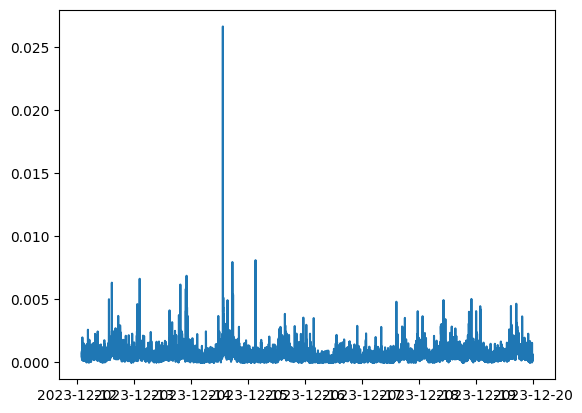

In [ ]:
plt.plot(ohlcv['timestamp'], ohlcv['range_rate'])
plt.show()

In [ ]:
# range_rateの概要（統計値）を表示する
ohlcv['range_rate'].describe()

statistic,value
str,f64
"""count""",11395.0
"""null_count""",0.0
"""mean""",0.000649
"""std""",0.000634
"""min""",2.3218e-7
"""max""",0.026654
"""median""",0.000521
"""25%""",0.000296
"""75%""",0.000836


In [ ]:
# rangeの概要（統計値）を表示する
ohlcv['range'].describe()

statistic,value
str,f64
"""count""",11395.0
"""null_count""",0.0
"""mean""",27.309437
"""std""",26.659581
"""min""",0.01
"""max""",1116.27
"""median""",21.91
"""25%""",12.55
"""75%""",35.09


## まとめ
2023年12月21日で試したみたところ、１本足での変化率は平均0.06%ぐらい。具体的な値としては27ドルぐらい。

これは１分の間のポジションをオープンしクローズする高頻度だと完璧に変化をあてても２７ドルしか鞘がとれないということ。0.06%のうち、手数料で往復0.02%とられることを考えると残り3分の2になって20ドルの鞘も難しいということらしい。

もうすこし長期でかんがてみようかなあ。